# Supplementary - The Human Connectome Hosts Connectivity In-strength Gradients

## Schaefer parcellation - Subject demographics

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load list of participants that Michael Schirner included in his tractography processing
subjects_all = pd.read_csv('/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Schaefer2018_HCP_S900/participants.tsv', sep='\t')
# load list of participants that we processed for this paper (some were exlcuded because of missing files)
subjects_included = pd.read_csv('/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Schaefer2018_HCP_S900/subjects_list.txt', header=None, names=['participant_id'])

In [3]:
# get subjects IDs that were excluded
# these subjects had missing files on the AWS and were thus excluded.
[sub for sub in subjects_all.participant_id if sub not in subjects_included.participant_id.values]

[102311, 162935, 300618, 310621, 565452, 861456, 894067, 994273, 996782]

In [29]:
age_range = np.array([subjects_all[subjects_all.participant_id==sub].Age.values for sub in subjects_all.participant_id if sub in subjects_included.participant_id.values])
sex = np.array([subjects_all[subjects_all.participant_id==sub].Sex.values for sub in subjects_all.participant_id if sub in subjects_included.participant_id.values])

In [30]:
# get age ranges of data
np.unique(age_range, return_counts=True)

(array(['22-25', '26-30', '31-35', '36+'], dtype=object),
 array([160, 339, 271,   6]))

In [8]:
print(f"Sample includes {np.sum(sex=='F')} female subjects and {np.sum(sex=='M')} male subjects.")

Sample includes 432 female subjects and 344 male subjects.


# Random parcellation 500 regions

This parcellation is based on [Aurina Arnatkeviciute et al. (2021)](https://pure.mpg.de/rest/items/item_3342685/component/file_3342686/content). We retrieved the data from https://zenodo.org/record/4733297#.Y3YzwezMK3I

In [109]:
import os
import mat73
import numpy as np
import nibabel as nb

from modules.visualization import *
from modules.helpers import *

from scipy.io import loadmat
from palettable.scientific.sequential import Davos_20

cmap_strength = Davos_20.mpl_colormap

dpi = 300
page_width = 2244  # pxl at 300 dpi

In [110]:
# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes"
regions_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Arnatkeviciute/modules"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/20_results"

In [111]:
significance_level = 0.01

In [112]:
# get inflated fsaverage for background
v_inflated_lh, f_inflated_lh = nb.freesurfer.io.read_geometry(
    data_path + '/Schaefer2018_HCP_S900/hcp_parcellation/fsaverage5/surf/lh.inflated')
v_inflated_rh, f_inflated_rh = nb.freesurfer.io.read_geometry(
    data_path + '/Schaefer2018_HCP_S900/hcp_parcellation/fsaverage5/surf/rh.inflated')

v_inflated_lh *= 1e-3
v_inflated_rh *= 1e-3

# combine left and right hemispheres
v_inflated_lh[:,0] = v_inflated_lh[:,0] - (v_inflated_lh[:,0].max() - v_inflated_lh[:,0].min())

v_inflated = np.concatenate([v_inflated_lh, v_inflated_rh])
f_inflated = np.concatenate([f_inflated_lh, f_inflated_rh+len(v_inflated_lh)])

In [113]:
# get fsaverage positions for random parcellation
vertex_labels_lh = np.genfromtxt(os.path.join(regions_path, 'lh.random500.txt'))
vertex_labels_rh = np.genfromtxt(os.path.join(regions_path, 'rh.random500.txt'))

surf_dict = loadmat(os.path.join(regions_path, 'inflated_vertices.mat'))
verts_lh = surf_dict['lh_inflated_verts']
verts_rh = surf_dict['rh_inflated_verts']

verts_lh *= 1e-3
verts_rh *= 1e-3

verts_lh[:,0] = verts_lh[:,0] - (verts_lh[:,0].max() - verts_lh[:,0].min())

v_lh = np.array([np.mean(verts_lh[np.where(vertex_labels_lh==vl)[0],:], axis=0) for vl in np.unique(vertex_labels_lh)[1:]])  # regions begin at index 1
v_rh = np.array([np.mean(verts_rh[np.where(vertex_labels_rh==vl)[0],:], axis=0) for vl in np.unique(vertex_labels_rh)[1:]])  # regions begin at index 1

v = np.concatenate([v_lh, v_rh])

#np.save(data_path + '/Arnatkeviciute/' + 'positions.npy', v)

In [114]:
# estimate mesh from vertices and fsaverage surface
tris_lh = surf_dict['lh_faces']
f_lh = compute_parcel_topology(vertex_labels_lh, tris_lh)

In [148]:
# load data
data_dict = mat73.loadmat(os.path.join(data_path, 'Arnatkeviciute/HCP_connectomes/HCP_random500ANDfslatlas20_iFOD2_NOSIFT_standard.mat'))

# extract weights
subjects = data_dict['SUBS']
weights_nsc = data_dict['ADJS']
number_of_subjects = len(subjects)

# remove subcortical regions (indices from personal communication with Aurina Arnatkeviciute 11/17/2022)
for i in range(number_of_subjects):
    weights_nsc[i] = np.delete(weights_nsc[i], np.s_[510:520], 0)
    weights_nsc[i] = np.delete(weights_nsc[i], np.s_[250:260], 0)
    weights_nsc[i] = np.delete(weights_nsc[i], np.s_[510:520], 1)
    weights_nsc[i] = np.delete(weights_nsc[i], np.s_[250:260], 1)

# compute average weights
avg_weights = np.mean(weights_nsc, axis=0)
number_of_regions = 500
number_of_regions_per_hemi = int(number_of_regions/2)

In [116]:
# compute instrength
instrength = np.sum(avg_weights, axis=0)

clim = np.percentile(instrength, [5,95])

#np.save(data_path + '/Arnatkeviciute/' + 'random500_instrength.npy', instrength)

In [117]:
# Plot Instrength distribution
# ----------------------------
plot_brain_data(v_inflated, f_inflated, instrength, figure_path + "/instrength_random500.png", cmap=cmap_strength, clim=clim, data_points=v, glyph_scaling=0.015)

#### Group-level spectral analysis

In [118]:
# Compute eigenmodes of mesh
l, e, m = spectral_decomposition(v_lh, f_lh, 100)

# compute spatial frequencies from eigenvalues
spatial_frequencies = np.sqrt(l[1:]) / (2*np.pi)  # exclude first eigenvalue because the component relates to zero frequency

In [119]:
# project instrength onto eigenbasis
instrength_lh = instrength[:number_of_regions_per_hemi]

# project instrength onto harmonics through massmatrix: see section 2.2 and 3.1 in Vallet and Lévy (2007; 'Spectral Geometry Processing with Manifold Harmonics') 
spectrum = instrength_lh.dot(m.dot(e[:,1:]))  

n_permutations = 10000
spectrum_perm = np.zeros((n_permutations, 99))
for i in range(n_permutations):
    spectrum_perm[i] = instrength_lh[np.random.permutation(range(number_of_regions_per_hemi))].dot(m.dot(e[:,1:]))

# normalized by original spectrum?
power_avg = spectrum**2 / np.sum(spectrum**2)
power_avg_perm = spectrum_perm**2 / np.sum(spectrum**2)

In [120]:
# p value calculation
p_values = np.sum(power_avg_perm >= power_avg, axis=0)/n_permutations
p_values_corrected = p_values * len(p_values)  # bonferroni

significance_mask = p_values_corrected <= significance_level

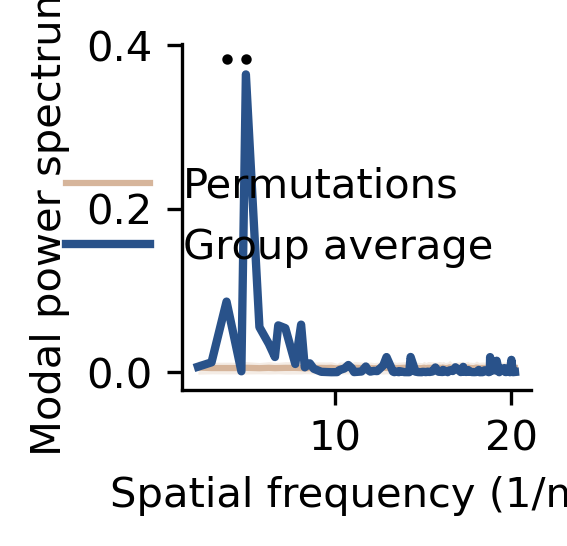

In [121]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

power_avg_perm_sd = np.std(power_avg_perm, axis=0)
power_avg_perm_mean = np.mean(power_avg_perm, axis=0)

ax.fill_between(spatial_frequencies, power_avg_perm_mean-power_avg_perm_sd, power_avg_perm_mean+power_avg_perm_sd, color='#d6b59b', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_avg_perm_mean, '#d6b59b', label = 'Permutations')
ax.plot(spatial_frequencies, power_avg, linewidth=2, color='#29528a', label='Group average')
ax.plot(spatial_frequencies[significance_mask], np.ones(sum(significance_mask))*ax.get_ylim()[1], 'k.', markersize=3)
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', useOffset=False)
plt.legend(frameon=False)
plt.savefig(os.path.join(figure_path, 'spectrum_group_random.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'spectrum_group_random.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [124]:
# Plot significant modes
# ----------------------
significant_modes = np.where(significance_mask)[0]
for sm in significant_modes:
    plot_brain_data(v_inflated, f_inflated, e[:,sm+1], figure_path + f"/mode{sm+1}_random500.png", cmap='spectral', clim=None, data_points=v_lh, glyph_scaling=0.015)
    
    print(f"mode {sm+1}: {int(1/spatial_frequencies[sm]*1000)} mm")

mode 3: 259 mm
mode 5: 202 mm


#### Subject-level spectral analysis

In [18]:
instrength_sub = np.sum(weights_nsc, axis=-1)

In [19]:
n_permutations = 10000

power = []
significant_modes = []
for sub in range(number_of_subjects):
    print(f"\rSubject {sub}", end="")
    
    # project instrength onto eigenbasis
    instrength_lh = instrength_sub[sub,:number_of_regions_per_hemi]
    power_original = (instrength_lh.dot(m.dot(e[:,1:])))**2    
    
    power_perm = np.zeros((n_permutations, 99))
    for i in range(n_permutations):
        power_perm[i] = instrength_lh[np.random.permutation(range(number_of_regions_per_hemi))].dot(m.dot(e[:,1:]))**2

    ## normalized by original spectrum?
    power.append(power_original / np.sum(power_original))
    power_perm = power_perm / np.sum(power_original)

    # p value calculation
    p_values = np.sum(power_perm >= power[sub], axis=0)/n_permutations
    p_values_corrected = p_values * len(p_values)  # bonferroni
    significance_mask = p_values_corrected <= significance_level

    significant_modes.append(np.where(significance_mask)[0])  # get significant modes
    
power = np.array(power)

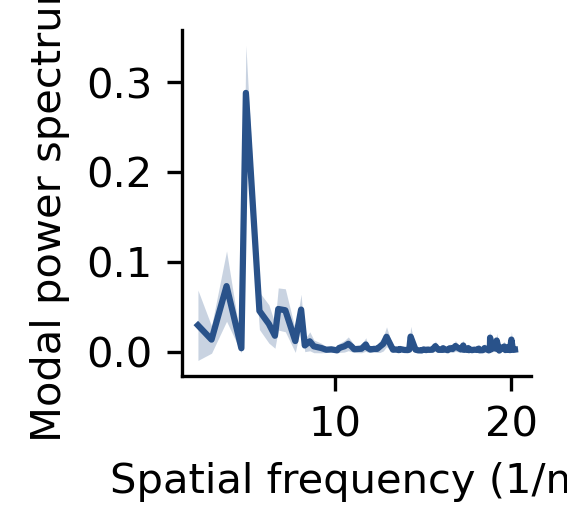

In [20]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

power_perm_sd = np.std(power, axis=0)
power_perm_mean = np.mean(power, axis=0)

ax.fill_between(spatial_frequencies, power_perm_mean-power_perm_sd, power_perm_mean+power_perm_sd, color='#29528a', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_perm_mean, '#29528a')
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(os.path.join(figure_path, 'spectrum_subjects_random.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'spectrum_subjects_random.svg'), dpi=300, transparent=False, bbox_inches='tight')

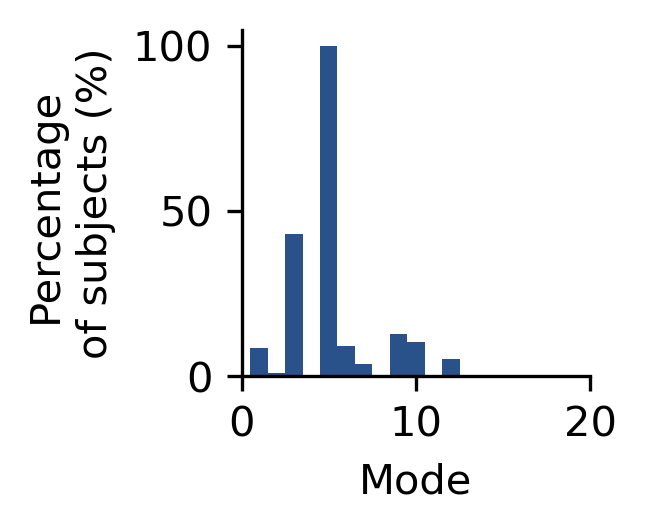

In [21]:
def flatten(l):
    return [item for sublist in l for item in sublist]

fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

ax.hist(np.array(flatten(significant_modes))+1, color='#29528a', bins=np.arange(-0.5, 100.5), weights=100*np.ones(len(flatten(significant_modes))) / len(significant_modes), linewidth=0.25)
ax.set_xlabel('Mode')
ax.set_ylabel('Percentage \nof subjects (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 50, 100])
ax.set_xlim([0,20])
#axins = ax.inset_axes([0.4, 0.4, 0.47, 0.47])
#axins.hist(np.array(flatten(significant_modes))+1, color='#29528a', bins=np.arange(-0.5, 100.5), weights=100*np.ones(len(flatten(significant_modes))) / len(significant_modes))
#axins.spines['right'].set_visible(False)
#axins.spines['top'].set_visible(False)
#axins.set_xlim([0,20])
plt.savefig(os.path.join(figure_path, 'sig_mode_distribution_random.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'sig_mode_distribution_random.svg'), dpi=300, transparent=False, bbox_inches='tight')

# Lausanne Connectome

This connectome was computed with deterministic tractography from 70 young healthy adults and parcellated according to the Lausanne atlas ([Hagmann et al., 2008](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.0060159)). This dataset is publicly available and was retrieved from [Zenodo](https://zenodo.org/record/2872624#.YUiBXp4za3I) (Griffa et al., 2019).

In [125]:
import os, sys
import mne
import robust_laplacian

import numpy as np
from scipy import io

from netneurotools import freesurfer
from netneurotools import datasets as nntdata
from palettable.scientific.sequential import Davos_20

cmap_strength = Davos_20.mpl_colormap

from modules.visualization import *

In [126]:
data_path = '/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes'
regions_path = '/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Griffa'
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/20_results"

In [127]:
significance_level = 0.01

In [128]:
# fetch fsaverage lausanne atlas 2008
lausanne = nntdata.fetch_cammoun2012(version='fsaverage')

# get region mapping and region labels
region_mapping_lh, _, labels_lh  = freesurfer.read_annot(lausanne['scale500'][0])
region_mapping_rh, _, labels_rh  = freesurfer.read_annot(lausanne['scale500'][1])

# combine labels and remove non-cortical regions
labels_lh = [l.decode('UTF-8') for l in labels_lh if l.decode('UTF-8') not in ['unknown', 'corpuscallosum']]
labels_rh = [l.decode('UTF-8') for l in labels_rh if l.decode('UTF-8') not in ['unknown', 'corpuscallosum']]
labels = np.concatenate([labels_lh, labels_rh])

# get centroids for parcels
verts, d = freesurfer.find_parcel_centroids(lhannot=lausanne['scale500'][0], rhannot=lausanne['scale500'][1], surf='inflated')
#v_lh = np.array([np.mean(verts_lh[np.where(region_mapping_lh==vl)[0],:], axis=0) for vl in np.unique(region_mapping_lh)])  # regions begin at index 1

# shift centroids for visualization
v_lh = verts[:len(labels_lh)]*1e-3
v_rh = verts[len(labels_lh):]*1e-3

v_lh[:,0] = v_lh[:,0] - (v_lh[:,0].max() - v_lh[:,0].min()) - 0.004

v = np.concatenate([v_lh, v_rh])

number_of_regions = len(v)

#np.save(data_path + '/Griffa' + '/positions.npy', v)

In [129]:
# load data
conn = io.loadmat(os.path.join(data_path,'Griffa/Individual_Connectomes_SC.mat'))
weights = conn['SC'][-1][0]

number_of_subjects = weights.shape[-1]

# remove self-connections
weights_nsc = [weights[:,:,i] - np.eye(np.shape(weights[:,:,i])[0])*np.diag(weights[:,:,i]) for i in range(70)]

# remove self-connections
weights_nsc = [weights[:,:,i] - np.eye(np.shape(weights[:,:,i])[0])*np.diag(weights[:,:,i]) for i in range(70)]

# mean across subjects
avg_weights = np.mean(weights_nsc, axis=0)

# make upper triangular matrices symmetric
avg_weights = avg_weights + avg_weights.T - np.diag(np.diag(avg_weights))

In [130]:
# compute instrength
instrength = np.sum(avg_weights, axis=0)

clim = np.percentile(instrength, [5,95])

#np.save(data_path + '/Griffa' + '/lausanne_instrength.npy', instrength)

In [52]:
# Plot Instrength distribution
# ----------------------------
plot_brain_data(v_inflated, f_inflated, instrength, figure_path + "/instrength_lausanne.png", cmap=cmap_strength, clim=clim, data_points=v)

#### Group-level spectral analysis

In [131]:
# build laplacian and massmatrix from point cloud
cotan_laplacian, m = robust_laplacian.point_cloud_laplacian(v_lh)

# solve generalized eigenvalue problem
l, e = sp.sparse.linalg.eigsh(cotan_laplacian, 100, m, sigma=0, which="LM")

# compute spatial frequencies from eigenvalues
spatial_frequencies = np.sqrt(l[1:]) / (2*np.pi)  # exclude first eigenvalue because the component relates to zero frequency

In [132]:
# project instrength onto eigenbasis
instrength_lh = instrength[:len(v_lh)]

# project instrength onto harmonics through massmatrix: see section 2.2 and 3.1 in Vallet and Lévy (2007; 'Spectral Geometry Processing with Manifold Harmonics') 
spectrum = instrength_lh.dot(m.dot(e[:,1:]))  

n_permutations = 10000
spectrum_perm = np.zeros((n_permutations, 99))
for i in range(n_permutations):
    spectrum_perm[i] = instrength_lh[np.random.permutation(range(len(v_lh)))].dot(m.dot(e[:,1:]))

# normalized by original spectrum?
power_avg = spectrum**2 / np.sum(spectrum**2)
power_avg_perm = spectrum_perm**2 / np.sum(spectrum**2)

In [133]:
# p value calculation
p_values = np.sum(power_avg_perm >= power_avg, axis=0) / n_permutations
p_values_corrected = p_values * len(p_values)  # bonferroni

significance_mask = p_values_corrected <= significance_level

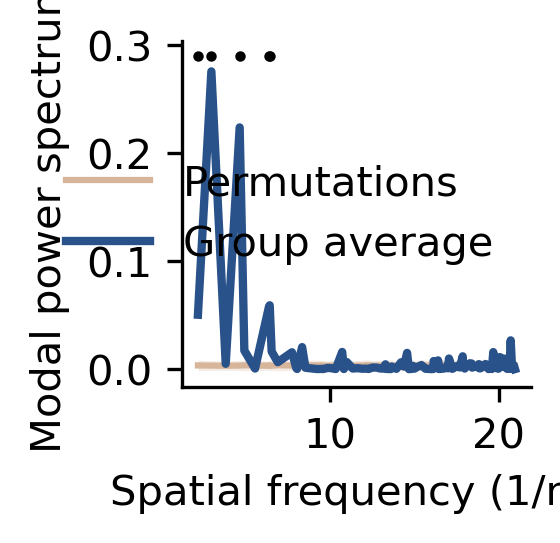

In [134]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

power_avg_perm_sd = np.std(power_avg_perm, axis=0)
power_avg_perm_mean = np.mean(power_avg_perm, axis=0)

ax.fill_between(spatial_frequencies, power_avg_perm_mean-power_avg_perm_sd, power_avg_perm_mean+power_avg_perm_sd, color='#d6b59b', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_avg_perm_mean, '#d6b59b', label = 'Permutations')
ax.plot(spatial_frequencies, power_avg, linewidth=2, color='#29528a', label='Group average')
ax.plot(spatial_frequencies[significance_mask], np.ones(sum(significance_mask))*ax.get_ylim()[1], 'k.', markersize=3)
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', useOffset=False)
plt.legend(frameon=False)
plt.savefig(os.path.join(figure_path, 'spectrum_group_lausanne.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'spectrum_group_lausanne.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [135]:
# Plot significant modes
# ----------------------
significant_modes = np.where(significance_mask)[0]
for sm in significant_modes:
    plot_brain_data(v_inflated, f_inflated, e[:,sm+1], figure_path + f"/mode{sm+1}_lausanne.png", cmap='spectral', clim=None, data_points=v_lh, glyph_scaling=0.015)
    
    print(f"mode {sm+1}: {int(1/spatial_frequencies[sm]*1000)} mm")

mode 1: 455 mm
mode 2: 334 mm
mode 4: 214 mm
mode 7: 156 mm
mode 8: 155 mm


#### Subject-level spectral analysis

In [18]:
instrength_sub = np.sum(weights_nsc, axis=-1)

In [19]:
n_permutations = 10000

power = []
significant_modes = []
for sub in range(number_of_subjects):
    print(f"\rSubject {sub}", end="")
    # project instrength onto eigenbasis
    instrength_lh = instrength_sub[sub,:len(v_lh)]
    power_original = (instrength_lh.dot(m.dot(e[:,1:])))**2    
    
    power_perm = np.zeros((n_permutations, 99))
    for i in range(n_permutations):
        power_perm[i] = instrength_lh[np.random.permutation(range(len(v_lh)))].dot(m.dot(e[:,1:]))**2

    ## normalized by original spectrum?
    power.append(power_original / np.sum(power_original))
    power_perm = power_perm / np.sum(power_original)

    # p value calculation
    p_values = np.sum(power_perm >= power[sub], axis=0)/n_permutations
    p_values_corrected = p_values * len(p_values)  # bonferroni
    significance_mask = p_values_corrected <= significance_level

    significant_modes.append(np.where(significance_mask)[0])  # get significant modes
    
power = np.array(power)

Subject 69

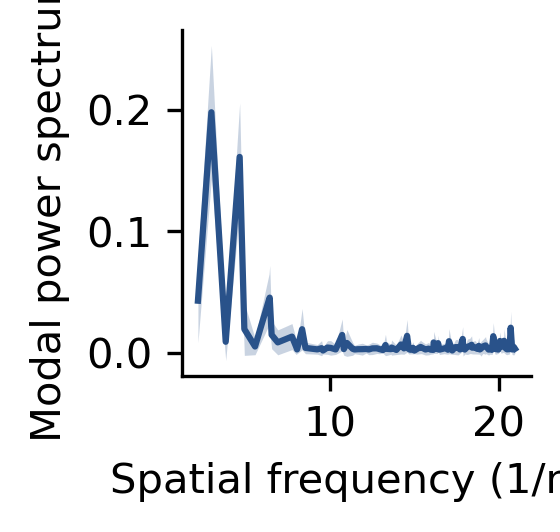

In [20]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

power_perm_sd = np.std(power, axis=0)
power_perm_mean = np.mean(power, axis=0)

ax.fill_between(spatial_frequencies, power_perm_mean-power_perm_sd, power_perm_mean+power_perm_sd, color='#29528a', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_perm_mean, '#29528a')
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(os.path.join(figure_path, 'spectrum_subjects_lausanne.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'spectrum_subjects_lausanne.svg'), dpi=300, transparent=False, bbox_inches='tight')

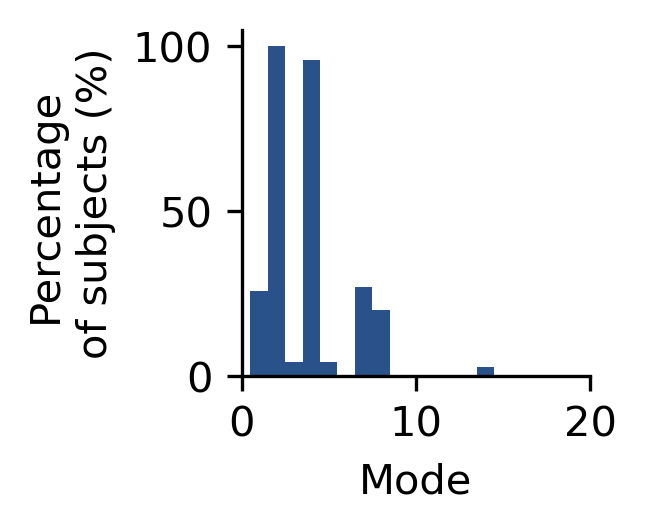

In [21]:
def flatten(l):
    return [item for sublist in l for item in sublist]

fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

ax.hist(np.array(flatten(significant_modes))+1, color='#29528a', bins=np.arange(-0.5, 100.5), weights=100*np.ones(len(flatten(significant_modes))) / len(significant_modes), linewidth=0.25)
ax.set_xlabel('Mode')
ax.set_ylabel('Percentage \nof subjects (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 50, 100])
ax.set_xlim([0,20])
#axins = ax.inset_axes([0.4, 0.4, 0.47, 0.47])
#axins.hist(np.array(flatten(significant_modes))+1, color='#29528a', bins=np.arange(-0.5, 100.5), weights=100*np.ones(len(flatten(significant_modes))) / len(significant_modes))
#axins.spines['right'].set_visible(False)
#axins.spines['top'].set_visible(False)
#axins.set_xlim([0,20])
plt.savefig(os.path.join(figure_path, 'sig_mode_distribution_lausanne.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'sig_mode_distribution_lausanne.svg'), dpi=300, transparent=False, bbox_inches='tight')

# Schaefer Connectome - 400 Regions

Here, we investigate an independent connectome obtained using the 400 regions Schaefer parcellation with the eNKI dataset. Furthermore, this connectome was constructed using the mean streamline count instead of the SIFT2 filtered weights.
This dataset is publicly available at [EBRAINs](https://search.kg.ebrains.eu/instances/Dataset/50c215bc-4c65-4f11-a4cd-98cc92750977) (Popovych et al., 2020).

In [136]:
import os, sys
import mne
import igl
import numpy as np
import pandas as pd

from modules.visualization import *
from modules.helpers import *

In [137]:
data_path="/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes"
regions_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Schaefer2018_HCP_S900/hcp_parcellation"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/20_results"

In [138]:
significance_level = 0.01

In [139]:
# load connectivity weights
df = pd.read_csv(os.path.join(data_path, 'hbp-d000038_SC-FC_HCP_eNKI_pub/Schaefer2018_400Parcels_17Networks/', 
                              'Averaged_SC_Schaefer2018_400Parcels_17Networks_eNKI_10M_count_MEAN.tsv'), sep='\t', header=None)
weights = df.values

# remove self-connections
avg_weights = weights - np.eye(np.shape(weights)[0])*np.diag(weights)

In [140]:
# load freesurfer fsaverage surface
regions_lh = mne.read_labels_from_annot('fsaverage5', 'Schaefer2018_400Parcels_17Networks_order', 'lh', surf_name='inflated', subjects_dir=regions_path, sort=False)
regions_rh = mne.read_labels_from_annot('fsaverage5', 'Schaefer2018_400Parcels_17Networks_order', 'rh', surf_name='inflated', subjects_dir=regions_path, sort=False)

regions_full = np.concatenate([regions_lh[1:], regions_rh[1:]])  # concatenate left and reight hemi + remove background+freesurfer medial wall

# get region positions
rr_lh, tris_lh = mne.read_surface(os.path.join(regions_path, 'fsaverage5/surf/lh.inflated'))
rr_rh, tris_rh = mne.read_surface(os.path.join(regions_path, 'fsaverage5/surf/rh.inflated'))

rr_lh *= 1e-3
rr_rh *= 1e-3

# combine left and right hemispheres
rr_lh[:,0] = rr_lh[:,0] - (rr_lh[:,0].max() - rr_lh[:,0].min())

v_lh = np.array([np.mean(rr_lh[r_lh.vertices,:], axis=0) for r_lh in regions_lh[1:]])  # regions begin at index 1
v_rh = np.array([np.mean(rr_rh[r_rh.vertices,:], axis=0) for r_rh in regions_rh[1:]])  # regions begin at index 1
v = np.concatenate([v_lh, v_rh])

number_of_regions = len(v)
number_of_regions_per_hemi = int(number_of_regions/2)

#np.save(data_path + '/hbp-d000038_SC-FC_HCP_eNKI_pub/' + 'positions.npy', v)

Reading labels from parcellation...
   read 201 labels from /Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Schaefer2018_HCP_S900/hcp_parcellation/fsaverage5/label/lh.Schaefer2018_400Parcels_17Networks_order.annot
Reading labels from parcellation...
   read 201 labels from /Users/dk/Documents/Charite/PhD/travelingwaves/data/connectomes/Schaefer2018_HCP_S900/hcp_parcellation/fsaverage5/label/rh.Schaefer2018_400Parcels_17Networks_order.annot


In [141]:
# compute instrength
instrength = np.sum(avg_weights, axis=0)

clim = np.percentile(instrength, [5,95])

#np.save(data_path + '/hbp-d000038_SC-FC_HCP_eNKI_pub/' + 'schaefer400_instrength.npy', instrength)

In [46]:
# Plot Instrength distribution
# ----------------------------
plot_brain_data(v_inflated, f_inflated, instrength, figure_path + "/instrength_eNKI.png", cmap=cmap_strength, clim=clim, data_points=v, glyph_scaling=0.015)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Group-level spectral analysis

In [142]:
# Generate parcel mesh
per_vertex_labels = np.zeros(len(rr_lh))
for i, reg_lh in enumerate(regions_lh):
    per_vertex_labels[reg_lh.vertices] = i
    
f_lh = compute_parcel_topology(per_vertex_labels, tris_lh)

In [143]:
# Compute eigenmodes of mesh
l, e, m = spectral_decomposition(v_lh, f_lh, 100)

# compute spatial frequencies from eigenvalues
spatial_frequencies = np.sqrt(l[1:]) / (2*np.pi)  # exclude first eigenvalue because the component relates to zero frequency

In [144]:
# project instrength onto eigenbasis
instrength_lh = instrength[:number_of_regions_per_hemi]

# project instrength onto harmonics through massmatrix: see section 2.2 and 3.1 in Vallet and Lévy (2007; 'Spectral Geometry Processing with Manifold Harmonics') 
spectrum = instrength_lh.dot(m.dot(e[:,1:]))  

n_permutations = 10000
spectrum_perm = np.zeros((n_permutations, 99))
for i in range(n_permutations):
    spectrum_perm[i] = instrength_lh[np.random.permutation(range(number_of_regions_per_hemi))].dot(m.dot(e[:,1:]))

# normalized by original spectrum?
power_avg = spectrum**2 / np.sum(spectrum**2)
power_avg_perm = spectrum_perm**2 / np.sum(spectrum**2)

In [145]:
# p value calculation
p_values = np.sum(power_avg_perm >= power_avg, axis=0) / n_permutations
p_values_corrected = p_values * len(p_values)  # bonferroni

significance_mask = p_values_corrected <= significance_level

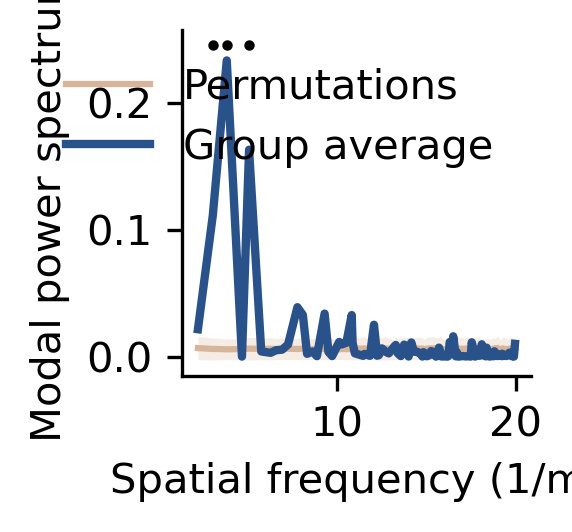

In [146]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

power_avg_perm_sd = np.std(power_avg_perm, axis=0)
power_avg_perm_mean = np.mean(power_avg_perm, axis=0)

ax.fill_between(spatial_frequencies, power_avg_perm_mean-power_avg_perm_sd, power_avg_perm_mean+power_avg_perm_sd, color='#d6b59b', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_avg_perm_mean, '#d6b59b', label = 'Permutations')
ax.plot(spatial_frequencies, power_avg, linewidth=2, color='#29528a', label='Group average')
ax.plot(spatial_frequencies[significance_mask], np.ones(sum(significance_mask))*ax.get_ylim()[1], 'k.', markersize=3)
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', useOffset=False)
plt.legend(frameon=False)
plt.savefig(os.path.join(figure_path, 'spectrum_group_schaefer400.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'spectrum_group_schaefer400.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [147]:
# Plot significant modes
# ----------------------
significant_modes = np.where(significance_mask)[0]
for sm in significant_modes:
    plot_brain_data(v_inflated, f_inflated, e[:,sm+1], figure_path + f"/mode{sm+1}_enki.png", cmap='spectral', clim=None, data_points=v_lh, glyph_scaling=0.015)
    
    print(f"mode {sm+1}: {int(1/spatial_frequencies[sm]*1000)} mm")

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


mode 2: 330 mm
mode 3: 262 mm
mode 5: 197 mm
